# **1. Install Dependencies**

In [1]:
!pip install transformers torch scikit-learn matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00


# **2. Import Libraries**

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_recall_fscore_support, matthews_corrcoef,
    mean_absolute_error, mean_squared_error,
    cohen_kappa_score, roc_auc_score
)

# **3. Load & Preprocess Dataset**

In [3]:
!pip install kagglehub -q

In [4]:
import kagglehub

# Download the latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [5]:
import os
import pandas as pd

# Construct the full file path
file_path = os.path.join(path, "IMDB Dataset.csv")

# Load the dataset
df = pd.read_csv(file_path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# Handle missing values
if df['review'].isnull().sum() > 0:
    df['review'].fillna(df['review'].mode()[0], inplace=True)

# Map sentiment to binary labels
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df = df[['review', 'label']].rename(columns={'review': 'text'})

print("Class distribution:")
print(df['label'].value_counts())

Class distribution:
label
1    25000
0    25000
Name: count, dtype: int64


# **4. Dataset Balancing & Splitting**

In [9]:
SAMPLE_SIZE = 5000
balanced_df = pd.concat([
    df[df['label'] == cls].sample(SAMPLE_SIZE, random_state=42)
    for cls in df['label'].unique()
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Split 70/10/20
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    balanced_df['text'], balanced_df['label'],
    test_size=0.3, stratify=balanced_df['label'], random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=2/3, stratify=temp_labels, random_state=42
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")


Train size: 7000, Val size: 1000, Test size: 2000


# **5. Dataset Class**

In [10]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# **Utility Functions (Train, Evaluate, Plot)**

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, optimizer, train_loader, val_loader, num_epochs=30, patience=5, save_path='best_model.pth'):
    train_loss_list, val_loss_list, train_acc_list, val_acc_list = [], [], [], []
    best_val_loss = float('inf')
    trigger_times = 0

    total_steps = len(train_loader) * num_epochs
    scheduler = get_scheduler(
        name='linear',
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, correct_train = 0, 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct_val += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_val / len(val_loader.dataset)

        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
            torch.save(model.state_dict(), save_path)
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping")
                break

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list


def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1]
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    metrics = {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_recall_fscore_support(all_labels, all_preds, average='binary')[0],
        "Recall": precision_recall_fscore_support(all_labels, all_preds, average='binary')[1],
        "F1-Score": precision_recall_fscore_support(all_labels, all_preds, average='binary')[2],
        "MCC": matthews_corrcoef(all_labels, all_preds),
        "MAE": mean_absolute_error(all_labels, all_preds),
        "RMSE": np.sqrt(mean_squared_error(all_labels, all_preds)),
        "Kappa": cohen_kappa_score(all_labels, all_preds),
        "AUC-ROC": roc_auc_score(all_labels, all_probs)
    }
    cm = confusion_matrix(all_labels, all_preds)
    TP, FN, FP = cm[1, 1], cm[1, 0], cm[0, 1]
    metrics["CSI"] = TP / (TP + FN + FP + 1e-6)

    return metrics, cm


def plot_curves(train_loss, val_loss, train_acc, val_acc, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss', marker='*')
    plt.plot(val_loss, label='Val Loss', marker='o')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy', marker='*')
    plt.plot(val_acc, label='Val Accuracy', marker='o')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{title}_training_curves.png', dpi=300)
    plt.show()


# **BERT Model**

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/438 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1: 100%|██████████| 438/438 [03:06<00:00,  2.35it/s]


Epoch 1: Train Loss=0.4897, Val Loss=0.3149, Train Acc=0.7371, Val Acc=0.8690


Epoch 2: 100%|██████████| 438/438 [03:00<00:00,  2.43it/s]


Epoch 2: Train Loss=0.3175, Val Loss=0.3166, Train Acc=0.8686, Val Acc=0.8690


Epoch 3: 100%|██████████| 438/438 [03:00<00:00,  2.43it/s]


Epoch 3: Train Loss=0.2578, Val Loss=0.3741, Train Acc=0.8909, Val Acc=0.8730


Epoch 4: 100%|██████████| 438/438 [02:59<00:00,  2.43it/s]


Epoch 4: Train Loss=0.2071, Val Loss=0.3595, Train Acc=0.9166, Val Acc=0.8750


Epoch 5: 100%|██████████| 438/438 [03:00<00:00,  2.43it/s]


Epoch 5: Train Loss=0.1690, Val Loss=0.3796, Train Acc=0.9359, Val Acc=0.8780


Epoch 6: 100%|██████████| 438/438 [03:00<00:00,  2.43it/s]


Epoch 6: Train Loss=0.1238, Val Loss=0.4708, Train Acc=0.9523, Val Acc=0.8730
Early stopping
BERT Final Metrics: {'Accuracy': 0.864, 'Precision': 0.837037037037037, 'Recall': 0.904, 'F1-Score': 0.8692307692307693, 'MCC': np.float64(0.7303408420536666), 'MAE': 0.136, 'RMSE': np.float64(0.3687817782917155), 'Kappa': np.float64(0.728), 'AUC-ROC': np.float64(0.9381700000000001), 'CSI': np.float64(0.7687074823395343)}


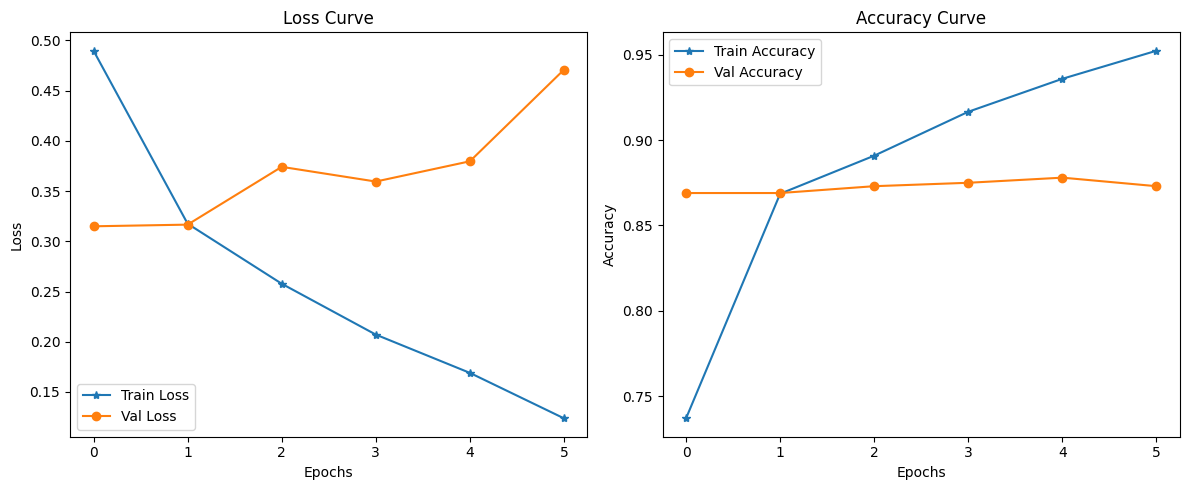

In [12]:
from transformers import get_scheduler

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TextDataset(train_texts, train_labels, bert_tokenizer)
val_dataset = TextDataset(val_texts, val_labels, bert_tokenizer)
test_dataset = TextDataset(test_texts, test_labels, bert_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load BERT model with increased dropout
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
).to(device)

# Optimizer with weight decay
bert_optimizer = AdamW(bert_model.parameters(), lr=2e-5, weight_decay=0.01)

# Train model
train_loss, val_loss, train_acc, val_acc = train_model(
    bert_model,
    bert_optimizer,
    train_loader,
    val_loader,
    num_epochs=30,
    patience=5,
    save_path='bert_best.pth'
)

# Load best model and evaluate
bert_model.load_state_dict(torch.load('bert_best.pth'))
bert_metrics, bert_cm = evaluate_model(bert_model, test_loader)

print("BERT Final Metrics:", bert_metrics)
plot_curves(train_loss, val_loss, train_acc, val_acc, "BERT")

# **RoBERTa Model**

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/438 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1: 100%|██████████| 438/438 [02:53<00:00,  2.53it/s]


Epoch 1: Train Loss=0.5115, Val Loss=0.3060, Train Acc=0.7359, Val Acc=0.8780


Epoch 2: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 2: Train Loss=0.3340, Val Loss=0.3418, Train Acc=0.8569, Val Acc=0.8760


Epoch 3: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 3: Train Loss=0.2931, Val Loss=0.3007, Train Acc=0.8786, Val Acc=0.8950


Epoch 4: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 4: Train Loss=0.2584, Val Loss=0.3057, Train Acc=0.8954, Val Acc=0.8970


Epoch 5: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 5: Train Loss=0.2410, Val Loss=0.3267, Train Acc=0.9043, Val Acc=0.8850


Epoch 6: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 6: Train Loss=0.2082, Val Loss=0.3822, Train Acc=0.9159, Val Acc=0.8850


Epoch 7: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 7: Train Loss=0.1902, Val Loss=0.2583, Train Acc=0.9259, Val Acc=0.8970


Epoch 8: 100%|██████████| 438/438 [02:50<00:00,  2.56it/s]


Epoch 8: Train Loss=0.1736, Val Loss=0.3146, Train Acc=0.9326, Val Acc=0.8920


Epoch 9: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 9: Train Loss=0.1537, Val Loss=0.3547, Train Acc=0.9439, Val Acc=0.8920


Epoch 10: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 10: Train Loss=0.1366, Val Loss=0.3861, Train Acc=0.9491, Val Acc=0.8920


Epoch 11: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 11: Train Loss=0.1224, Val Loss=0.4046, Train Acc=0.9554, Val Acc=0.8940


Epoch 12: 100%|██████████| 438/438 [02:50<00:00,  2.57it/s]


Epoch 12: Train Loss=0.1159, Val Loss=0.3808, Train Acc=0.9566, Val Acc=0.8920
Early stopping
RoBERTa Final Metrics: {'Accuracy': 0.895, 'Precision': 0.8657407407407407, 'Recall': 0.935, 'F1-Score': 0.8990384615384616, 'MCC': np.float64(0.7925401994813139), 'MAE': 0.105, 'RMSE': np.float64(0.324037034920393), 'Kappa': np.float64(0.79), 'AUC-ROC': np.float64(0.9611240000000001), 'CSI': np.float64(0.8165938857496996)}


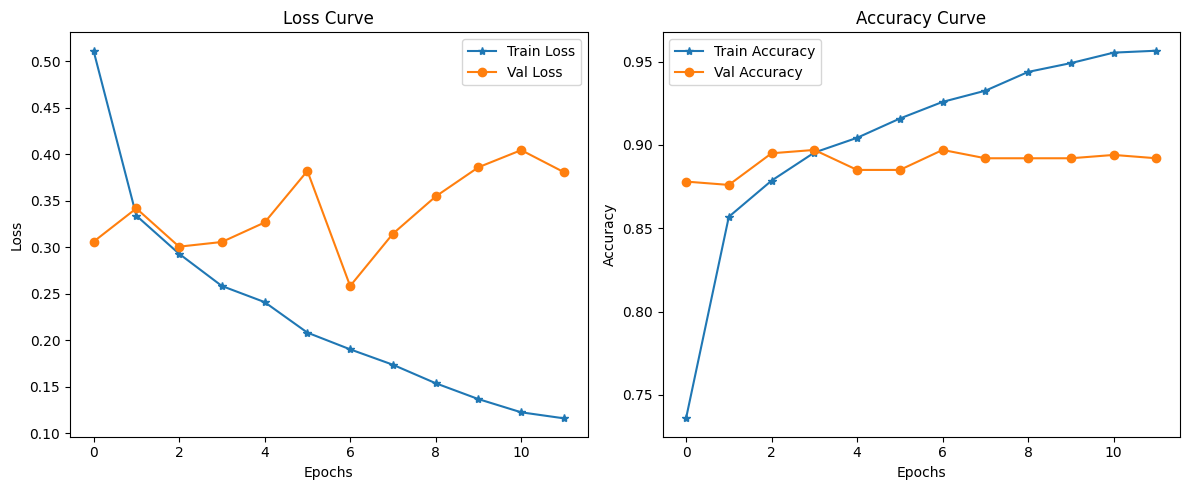

In [13]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Prepare datasets
train_dataset = TextDataset(train_texts, train_labels, roberta_tokenizer)
val_dataset = TextDataset(val_texts, val_labels, roberta_tokenizer)
test_dataset = TextDataset(test_texts, test_labels, roberta_tokenizer)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load RoBERTa model with custom dropout settings
roberta_model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
).to(device)

# Optimizer with weight decay
roberta_optimizer = AdamW(roberta_model.parameters(), lr=2e-5, weight_decay=0.01)

# Train the model
train_loss, val_loss, train_acc, val_acc = train_model(
    roberta_model,
    roberta_optimizer,
    train_loader,
    val_loader,
    num_epochs=30,
    patience=5,
    save_path='roberta_best.pth'
)

# Load best model and evaluate
roberta_model.load_state_dict(torch.load('roberta_best.pth'))
roberta_metrics, roberta_cm = evaluate_model(roberta_model, test_loader)

print("RoBERTa Final Metrics:", roberta_metrics)
plot_curves(train_loss, val_loss, train_acc, val_acc, "RoBERTa")

# **DistilBERT**

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 438/438 [01:43<00:00,  4.24it/s]


Epoch 1: Train Loss=0.4050, Val Loss=0.3694, Train Acc=0.8176, Val Acc=0.8290


Epoch 2: 100%|██████████| 438/438 [01:44<00:00,  4.21it/s]


Epoch 2: Train Loss=0.2365, Val Loss=0.3641, Train Acc=0.9066, Val Acc=0.8440


Epoch 3: 100%|██████████| 438/438 [01:43<00:00,  4.23it/s]


Epoch 3: Train Loss=0.1244, Val Loss=0.4532, Train Acc=0.9571, Val Acc=0.8530


Epoch 4: 100%|██████████| 438/438 [01:43<00:00,  4.22it/s]


Epoch 4: Train Loss=0.0626, Val Loss=0.5257, Train Acc=0.9823, Val Acc=0.8450


Epoch 5: 100%|██████████| 438/438 [01:43<00:00,  4.23it/s]


Epoch 5: Train Loss=0.0442, Val Loss=0.6216, Train Acc=0.9859, Val Acc=0.8420


Epoch 6: 100%|██████████| 438/438 [01:43<00:00,  4.22it/s]


Epoch 6: Train Loss=0.0348, Val Loss=0.6580, Train Acc=0.9899, Val Acc=0.8540


Epoch 7: 100%|██████████| 438/438 [01:43<00:00,  4.22it/s]


Epoch 7: Train Loss=0.0188, Val Loss=0.6745, Train Acc=0.9947, Val Acc=0.8440
Early stopping
DistilBERT Final Metrics: {'Accuracy': 0.8605, 'Precision': 0.8659898477157361, 'Recall': 0.853, 'F1-Score': 0.8594458438287154, 'MCC': np.float64(0.7210811261903013), 'MAE': 0.1395, 'RMSE': np.float64(0.37349698793966196), 'Kappa': np.float64(0.721), 'AUC-ROC': np.float64(0.940451), 'CSI': np.float64(0.7535335682389279)}


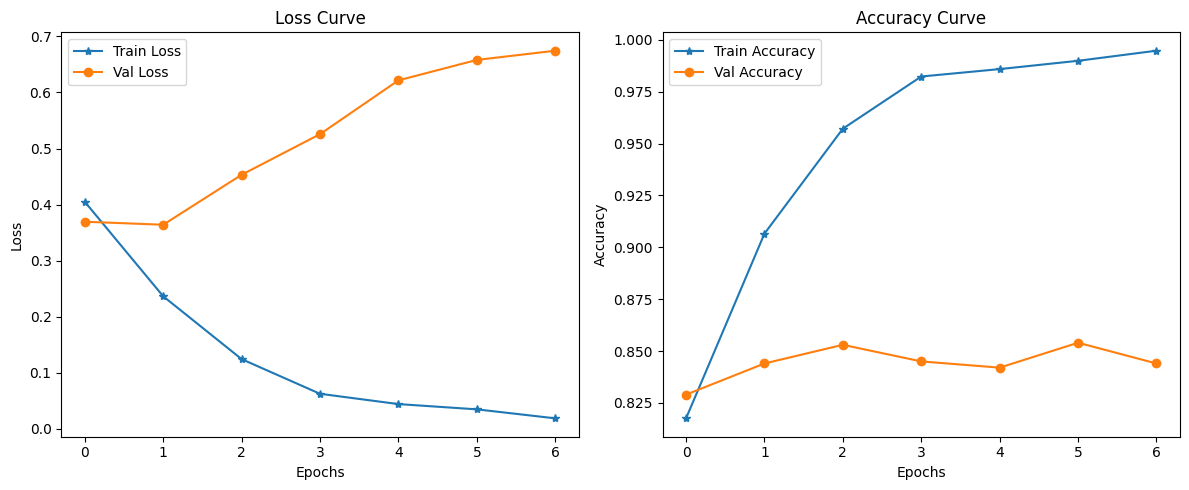

In [14]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Prepare datasets
train_dataset = TextDataset(train_texts, train_labels, distilbert_tokenizer)
val_dataset = TextDataset(val_texts, val_labels, distilbert_tokenizer)
test_dataset = TextDataset(test_texts, test_labels, distilbert_tokenizer)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model
distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
).to(device)

# Optimizer
distilbert_optimizer = AdamW(distilbert_model.parameters(), lr=2e-5, weight_decay=0.01)

# Train
train_loss, val_loss, train_acc, val_acc = train_model(
    distilbert_model,
    distilbert_optimizer,
    train_loader,
    val_loader,
    num_epochs=30,
    patience=5,
    save_path='distilbert_best.pth'
)

# Evaluate
distilbert_model.load_state_dict(torch.load('distilbert_best.pth'))
distilbert_metrics, distilbert_cm = evaluate_model(distilbert_model, test_loader)

print("DistilBERT Final Metrics:", distilbert_metrics)
plot_curves(train_loss, val_loss, train_acc, val_acc, "DistilBERT")


# **ALBERT**

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


Epoch 1: Train Loss=0.4138, Val Loss=0.3217, Train Acc=0.8136, Val Acc=0.8640


Epoch 2: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


Epoch 2: Train Loss=0.2625, Val Loss=0.3232, Train Acc=0.8953, Val Acc=0.8650


Epoch 3: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


Epoch 3: Train Loss=0.1719, Val Loss=0.3703, Train Acc=0.9347, Val Acc=0.8650


Epoch 4: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


Epoch 4: Train Loss=0.1105, Val Loss=0.4043, Train Acc=0.9549, Val Acc=0.8500


Epoch 5: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


Epoch 5: Train Loss=0.0679, Val Loss=0.4459, Train Acc=0.9766, Val Acc=0.8630


Epoch 6: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


Epoch 6: Train Loss=0.0549, Val Loss=0.4355, Train Acc=0.9806, Val Acc=0.8680
Early stopping
ALBERT Final Metrics: {'Accuracy': 0.867, 'Precision': 0.8605108055009824, 'Recall': 0.876, 'F1-Score': 0.8681863230921705, 'MCC': np.float64(0.7341189369024478), 'MAE': 0.133, 'RMSE': np.float64(0.3646916505762094), 'Kappa': np.float64(0.734), 'AUC-ROC': np.float64(0.941093), 'CSI': np.float64(0.7670753058081652)}


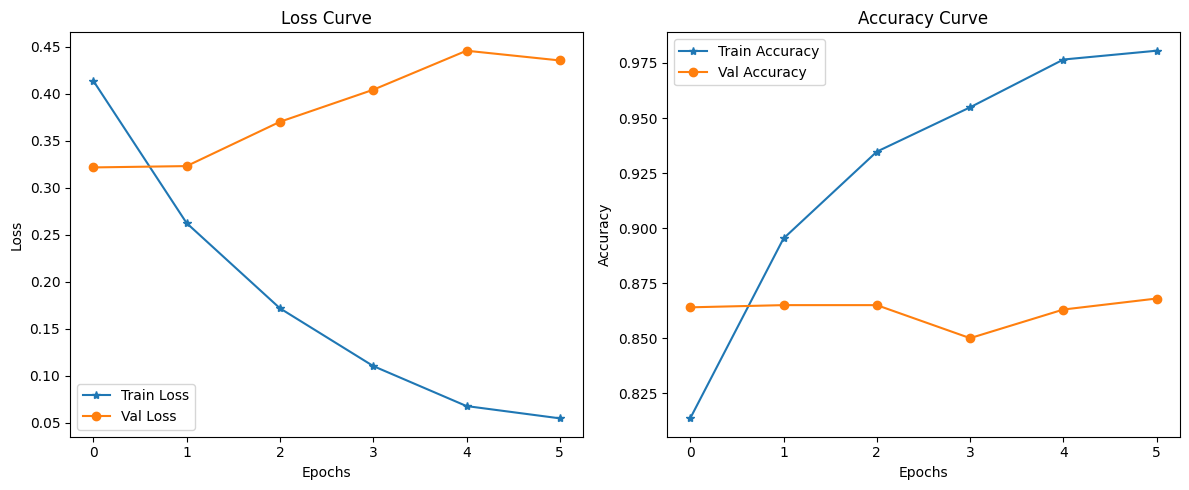

In [15]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification

# Tokenizer
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Dataset
train_dataset = TextDataset(train_texts, train_labels, albert_tokenizer)
val_dataset = TextDataset(val_texts, val_labels, albert_tokenizer)
test_dataset = TextDataset(test_texts, test_labels, albert_tokenizer)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model
albert_model = AlbertForSequenceClassification.from_pretrained(
    'albert-base-v2',
    num_labels=2
).to(device)

# Optimizer
albert_optimizer = AdamW(albert_model.parameters(), lr=2e-5, weight_decay=0.01)

# Train
train_loss, val_loss, train_acc, val_acc = train_model(
    albert_model,
    albert_optimizer,
    train_loader,
    val_loader,
    num_epochs=30,
    patience=5,
    save_path='albert_best.pth'
)

# Evaluate
albert_model.load_state_dict(torch.load('albert_best.pth'))
albert_metrics, albert_cm = evaluate_model(albert_model, test_loader)

print("ALBERT Final Metrics:", albert_metrics)
plot_curves(train_loss, val_loss, train_acc, val_acc, "ALBERT")


# **XLNet**

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 1/438 [00:00<05:07,  1.42it/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 438/438 [03:32<00:00,  2.06it/s]


Epoch 1: Train Loss=0.3709, Val Loss=0.3043, Train Acc=0.8256, Val Acc=0.8810


Epoch 2: 100%|██████████| 438/438 [03:30<00:00,  2.08it/s]


Epoch 2: Train Loss=0.2157, Val Loss=0.2927, Train Acc=0.9189, Val Acc=0.8780


Epoch 3: 100%|██████████| 438/438 [03:31<00:00,  2.07it/s]


Epoch 3: Train Loss=0.1313, Val Loss=0.3373, Train Acc=0.9551, Val Acc=0.8680


Epoch 4: 100%|██████████| 438/438 [03:31<00:00,  2.07it/s]


Epoch 4: Train Loss=0.0754, Val Loss=0.4580, Train Acc=0.9771, Val Acc=0.8670


Epoch 5: 100%|██████████| 438/438 [03:31<00:00,  2.07it/s]


Epoch 5: Train Loss=0.0505, Val Loss=0.4841, Train Acc=0.9833, Val Acc=0.8770


Epoch 6: 100%|██████████| 438/438 [03:31<00:00,  2.07it/s]


Epoch 6: Train Loss=0.0309, Val Loss=0.5623, Train Acc=0.9891, Val Acc=0.8720


Epoch 7: 100%|██████████| 438/438 [03:31<00:00,  2.07it/s]


Epoch 7: Train Loss=0.0198, Val Loss=0.5853, Train Acc=0.9940, Val Acc=0.8700
Early stopping
XLNet Final Metrics: {'Accuracy': 0.895, 'Precision': 0.8903162055335968, 'Recall': 0.901, 'F1-Score': 0.8956262425447317, 'MCC': np.float64(0.7900568861437773), 'MAE': 0.105, 'RMSE': np.float64(0.324037034920393), 'Kappa': np.float64(0.79), 'AUC-ROC': np.float64(0.9612250000000001), 'CSI': np.float64(0.8109810973798549)}


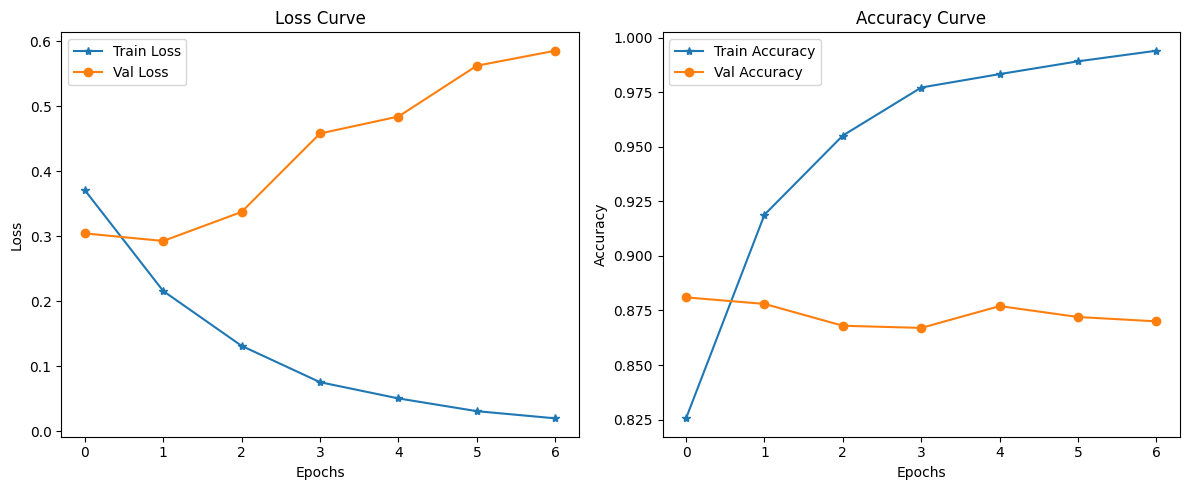

In [16]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# Tokenizer
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Dataset
train_dataset = TextDataset(train_texts, train_labels, xlnet_tokenizer)
val_dataset = TextDataset(val_texts, val_labels, xlnet_tokenizer)
test_dataset = TextDataset(test_texts, test_labels, xlnet_tokenizer)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model
xlnet_model = XLNetForSequenceClassification.from_pretrained(
    'xlnet-base-cased',
    num_labels=2
).to(device)

# Optimizer
xlnet_optimizer = AdamW(xlnet_model.parameters(), lr=2e-5, weight_decay=0.01)

# Train
train_loss, val_loss, train_acc, val_acc = train_model(
    xlnet_model,
    xlnet_optimizer,
    train_loader,
    val_loader,
    num_epochs=30,
    patience=5,
    save_path='xlnet_best.pth'
)

# Evaluate
xlnet_model.load_state_dict(torch.load('xlnet_best.pth'))
xlnet_metrics, xlnet_cm = evaluate_model(xlnet_model, test_loader)

print("XLNet Final Metrics:", xlnet_metrics)
plot_curves(train_loss, val_loss, train_acc, val_acc, "XLNet")
